In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import mlflow
import wandb
import seaborn as sns
from IPython.display import display, clear_output
import PIL.Image
import time
import imageio
import os
%matplotlib inline

from nets.Agent import Agent
from nets.Policy import Policy

In [2]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

# Initialize Weights & Biases
wandb.init(project="PG-MountainCarContinuous", config={
    "episodes": 1000,
    "gamma": 0.99,
    "learning_rate": 1e-4,
    "state_size": state_size,  # Dynamically set based on environment
    "action_size": action_size,  # Dynamically set based on environment
    "random_seed": 42,
    "fc1_units": 256,
    "fc2_units": 128
})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Start an MLflow run
mlflow.start_run()
mlflow.log_params(wandb.config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amoz (arashmozhdehi). Use `wandb login --relogin` to force relogin


In [3]:
# Initialize the policy and agent with configurations from wandb
policy = Policy(state_size=wandb.config.state_size, action_size=wandb.config.action_size,
                seed=wandb.config.random_seed, fc1_units=wandb.config.fc1_units, 
                fc2_units=wandb.config.fc2_units)
agent = Agent(policy=policy, learning_rate=wandb.config.learning_rate, gamma=wandb.config.gamma)

In [4]:
os.makedirs('videos', exist_ok=True)
os.makedirs('check_points', exist_ok=True)

In [5]:
def display_frames_as_gif(frames, path):
    with imageio.get_writer(path, mode='I', fps=30) as writer:
        for frame in frames:
            display(PIL.Image.fromarray(frame))
            clear_output(wait=True)
            writer.append_data(frame)

In [6]:
def load_checkpoint(agent, path):
    if os.path.exists(path):
        agent.load_checkpoint(path)
        print("Loaded checkpoint from:", path)
    else:
        print("No checkpoint found at:", path)

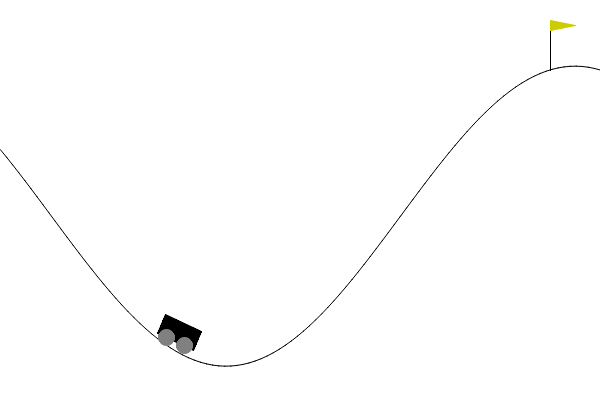

In [8]:
def train_agent(n_episodes=3000, max_t=300, print_every=100, save_every=500, start_from_checkpoint=False):
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    # Determine the starting episode based on the checkpoint
    last_checkpoint_episode = 0
    if start_from_checkpoint:
        checkpoint_files = [f for f in os.listdir('check_points') if f.endswith('.pth')]
        if checkpoint_files:
            last_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
            last_checkpoint_episode = int(last_checkpoint.split('_')[1].split('.')[0])
            agent.policy.load_state_dict(torch.load(os.path.join('check_points', last_checkpoint)))

    for i_episode in range(last_checkpoint_episode + 1, n_episodes + 1):
        state = env.reset()
        if isinstance(state, tuple):
                state = np.array(state[0])
        score = 0
        frames = []
        for t in range(max_t):
            action, log_prob = agent.act(state)
            # next_state, reward, done, _ = env.step(action)
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.store_transition(log_prob, reward)  # Store log_prob and reward
            state = next_state
            score += reward
            
            # Optionally capture the frame for rendering
            frame = env.render()  # Ensure to get RGB frames
            frames.append(frame)
            
            if terminated or truncated:
                break

        scores_deque.append(score)
        scores.append(score)
        wandb.log({"Average Score": np.mean(scores_deque)})
        mlflow.log_metric("Score", score, step=i_episode)

        # Learning step
        agent.learn()

        # Save the videos for the episode
        if frames:
            video_path = os.path.join('videos', f'video_episode_{i_episode}.gif')
            display_frames_as_gif(frames, video_path)

        # Save model checkpoint
        if i_episode % save_every == 0:
            checkpoint_path = os.path.join('check_points', f'checkpoint_{i_episode}.pth')
            torch.save(agent.policy.state_dict(), checkpoint_path)
        
    mlflow.end_run()
    return scores

# Now you can specify whether to start from a checkpoint
scores = train_agent(start_from_checkpoint=True)

wandb.finish()